# GBM Hyperparameter Tuning with sklearn

## Imports & Settings

In [70]:
from time import time
import numpy as np
import pandas as pd
import warnings
# there is now a faster (experimental) HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection._split import _BaseKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from itertools import product
import joblib
from pathlib import Path

warnings.filterwarnings('ignore')
np.random.seed(42)

## Create one-hot encoding

In [2]:
def get_one_hot_data(df, cols=('year', 'month', 'age', 'msize')):
    cols = list(cols)
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '').replace(' ', '_').lower() for c in df.columns})

## Create holdout test set

In [3]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(target.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Custom TimeSeriesSplit

In [12]:
class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    """

    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.0):
        if not isinstance(t1, pd.Series):
            raise ValueError("Label Through Dates must be a pd.Series")
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo

    def split(self, X, y=None, groups=None):
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError("X and DateValues must have the same index")
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0] * self.pctEmbargo)
        test_starts = [(i[0], i[-1] + 1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i, j in test_starts:
            t0 = self.t1.index[i]  # start of test set
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1 <= t0].index)
            if maxT1Idx <= X.shape[0]:
                # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx + mbrg :]))
                yield train_indices, test_indices       

## Instantiate GradientBoostingClassifier

In [38]:
gb_clf = GradientBoostingClassifier(loss='log_loss',
                                    learning_rate=0.1,
                                    n_estimators=100,
                                    subsample=1.0,
                                    criterion='friedman_mse',
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_depth=3,
                                    min_impurity_decrease=0.0,
                                    init=None,
                                    random_state=None,
                                    max_features=None,
                                    verbose=0,
                                    max_leaf_nodes=None,
                                    warm_start=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=None,
                                    tol=0.0001)

## Load Data

We use the dataset generated by the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) from [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) that needs to be executed first.

In [7]:
def get_data(start='2010', end='2018', holding_period=1, dropna=False):
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()

    y = (df[target] > 0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

In [25]:
# y, features = get_data()
# X = get_one_hot_data(features).dropna()

# y, X, y_test, X_test = get_holdout_set(target=y,
#                                        features=X)
X = pd.read_csv('../../Advances-in-Financial-ML/cache/X.csv', index_col=0, parse_dates=True)
y = pd.read_csv('../../Advances-in-Financial-ML/cache/y.csv', index_col=0, parse_dates=True)
y["t1"] = pd.to_datetime(y["t1"]).fillna(0)

In [27]:
n_splits = 3
cv = PurgedKFold(n_splits=n_splits, t1=y["t1"], pctEmbargo=0.01)

In [ ]:
data_path = Path('data')
if not data_path.exists():
    data_path.mkdir()

In [ ]:
with pd.HDFStore(data_path / 'tuning_sklearn_gbm.h5') as store:
    store.put('holdout/features', X_test)
    store.put('holdout/target', y_test)
    store.put('cv/target', y)
    store.put('cv/features', X)    

## Setup GridSearchCV

The [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class in sklearn's [model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) module facilitates the systematic evaluation of all combinations of the hyperparameter values that we would like to test.
 
In the following code, we will illustrate this functionality for seven tuning parameters that will result in a total of 24 x 32 x 4 = 576 different model configurations.

### Parameter Grid

First we define the cross-validation iterator:

cv = OneStepTimeSeriesSplit(n_splits=n_splits)

And next the parameter grid

In [31]:
param_grid = dict(
        learning_rate=[.01, .1, .2],
        max_depth=list(range(3, 13, 3)),
        max_features=['sqrt', .8, 1],
        min_impurity_decrease=[0, .01],
        min_samples_split=[10, 50],
        n_estimators=[100, 300],
        subsample=[.8, 1])
AVERAGE = "macro"

In [29]:
all_params = list(product(*param_grid.values()))
print('# Models = :', len(all_params))

# Models = : 576


In [44]:
def multi_f1(y_true, y_pred, average=AVERAGE):
    f1 =  f1_score(y_true, y_pred, average='macro')
    print(f"{f1 = }")
    return f1

### Instantiate GridSearchCV

In [49]:
gs = GridSearchCV(gb_clf,
                  param_grid,
                  cv=cv,
                  scoring='f1_macro',
                  verbose=3,
                  n_jobs=-1,
                  return_train_score=True)

### Fit GridSearchCV

This can take several days...

In [50]:
start = time()
gs.fit(X=X, y=y["bin"])
done = time()

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=0.507, test=0.311) total time=  38.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.397, test=0.314) total time=  15.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=0.505, test=0.313) total time=  54.6s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.423, test=0.322) total time=  38.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, 

[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.401, test=0.314) total time=  13.5s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.400, test=0.314) total time=  14.4s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=0.510, test=0.313) total time=  57.4s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.400, test=0.314) total time=  19.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=0.509, test=0.321) total time=  54.5s
[CV 3/3] END learni

[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=0.440, test=0.330) total time=  37.7s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.426, test=0.256) total time=  14.9s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=0.599, test=0.267) total time=  53.8s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.446, test=0.250) total time=  37.1s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=0.477, test=0.320) total time= 2.2min
[CV 2/3] END 

[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=0.440, test=0.332) total time=  43.5s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.426, test=0.256) total time=  18.6s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=0.593, test=0.265) total time=  58.3s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.325, test=0.269) total time=  45.1s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.456, test=0.250) total time=  42.1s
[CV 1/3] END learning

[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.402, test=0.313) total time=  11.8s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.401, test=0.313) total time=  12.7s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=0.505, test=0.316) total time=  48.0s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.398, test=0.314) total time=  18.6s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=0.508, test=0.314) total time=  48.8s
[CV 3/3] 

[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.426, test=0.257) total time=  11.6s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.312, test=0.268) total time=  12.5s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=0.442, test=0.352) total time=  47.1s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.424, test=0.257) total time=  18.4s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=0.598, test=0.267) total time=  48.0s
[CV 1/3] 

[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.311, test=0.256) total time=  11.7s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.425, test=0.254) total time=  12.4s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=0.597, test=0.269) total time=  46.7s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.310, test=0.261) total time=  18.6s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=0.434, test=0.350) total time=  48.4s
[CV 2/3] 

[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=0.600, test=0.266) total time=  37.4s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.312, test=0.249) total time=  15.1s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=0.440, test=0.335) total time=  54.0s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.323, test=0.265) total time=  37.6s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=0.603, test=0.272) total time= 2.2min
[CV 1/3] END 

[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=0.509, test=0.320) total time=  43.9s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.396, test=0.313) total time=  19.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=0.507, test=0.318) total time=  59.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.424, test=0.325) total time=  45.5s
[CV 3/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.421, test=0.323) total time=  43.4s
[CV 3/3] END learning

[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.421, test=0.255) total time=  13.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.313, test=0.264) total time=  14.3s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=0.596, test=0.265) total time=  56.0s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.313, test=0.260) total time=  19.1s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=0.442, test=0.346) total time=  54.0s
[CV 2/3] END learni

[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=0.596, test=0.269) total time=  42.9s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.309, test=0.255) total time=  18.6s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=0.447, test=0.339) total time=  58.9s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.456, test=0.251) total time=  44.6s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.323, test=0.262) total time=  42.8s
[CV 2/3] END learning

[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.312, test=0.264) total time=  13.3s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.425, test=0.254) total time=  14.1s
[CV 1/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=0.434, test=0.334) total time=  56.5s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.419, test=0.256) total time=  18.9s
[CV 2/3] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=0.596, test=0.269) total time=  53.5s
[CV 1/3] END learni

[CV 3/3] END learning_rate=0.1, max_depth=6, max_features=1, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=0.958, test=0.365) total time=  37.0s
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.301) total time= 2.3min
[CV 1/3] END learning_rate=0.1, max_depth=9, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.384) total time=  45.6s
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=1.000, test=0.383) total time=  51.4s
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.995, test=0.371) total time=  44.3s
[CV 2/3] END 

[CV 1/3] END learning_rate=0.1, max_depth=9, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.379) total time= 1.7min
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=1.000, test=0.364) total time= 2.2min
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.996, test=0.365) total time= 1.8min
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.985, test=0.347) total time=  20.5s
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.987, test=0.360) total time=  23.7s
[CV 2/3] END learning_ra

[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=1.000, test=0.302) total time= 1.1min
[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=1.000, test=0.300) total time= 3.4min
[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=1.000, test=0.300) total time= 1.1min
[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=1.000, test=0.379) total time= 9.0min
[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.370) total time= 1.7min
[CV 2/3] END learni

[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.364) total time=  54.0s
[CV 1/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.945, test=0.394) total time=  18.1s
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.951, test=0.364) total time=  20.1s
[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=1.000, test=0.389) total time= 1.5min
[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=1.000, test=0.402) total time= 1.1min
[CV 1/3] END learning_rate=

[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.299) total time= 2.3min
[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.296) total time= 6.8min
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.358) total time= 2.0min
[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.387) total time=  26.4s
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.351) total time=  35.7s
[CV 2/3] END learning

[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.361) total time= 2.3min
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.365) total time= 6.9min
[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=1.000, test=0.302) total time= 1.7min
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=1.000, test=0.361) total time= 2.7min
[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.999, test=0.376) total time=  18.6s
[CV 2/3] END lear

[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=1.000, test=0.365) total time= 2.0min
[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.372) total time= 2.2min
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.376) total time= 1.7min
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.370) total time=  23.9s
[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=1.000, test=0.288) total time=  33.7s
[CV 3/3] END learn

[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=1.000, test=0.369) total time= 2.8min
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=1.000, test=0.363) total time= 8.4min
[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=1.000, test=0.292) total time= 1.8min
[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.290) total time=  35.1s
[CV 2/3] END learning_rate=0.1, max_depth=12, max_features=1, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=0.999, test=0.300) total time=  34.7s
[CV 3/3] END learning_rate

[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.304) total time= 1.1min
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=0.8;, score=(train=0.977, test=0.304) total time=  18.0s
[CV 1/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=0.8;, score=(train=1.000, test=0.415) total time=  47.0s
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=0.8;, score=(train=0.999, test=0.296) total time=  41.5s
[CV 1/3] END learning_rate=0.1, max_depth=12, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=1.000, test=0.380) total time= 1.3min
[CV 1/3] END learning_rate=0

[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=0.8;, score=(train=0.985, test=0.288) total time=  17.5s
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.982, test=0.359) total time=  21.8s
[CV 3/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0.01, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=1.000, test=0.349) total time=  49.7s
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=sqrt, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=1.000, test=0.367) total time= 1.5min
[CV 3/3] END learning_rate=0.1, max_depth=12, max_features=sqrt, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=1.000, test=0.382) total time= 1.2min
[CV 3/3] END learning_rate

[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=0.992, test=0.289) total time=  22.7s
[CV 1/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=10, n_estimators=300, subsample=1;, score=(train=1.000, test=0.378) total time= 1.1min
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.979, test=0.290) total time=  18.7s
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=1.000, test=0.302) total time=  58.2s
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=1, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.966, test=0.297) total time=  19.5s
[CV 3/3] END learning_rate=0.1, max_depth=

[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=sqrt, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.998, test=0.306) total time=  53.6s
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=0.8, min_impurity_decrease=0, min_samples_split=10, n_estimators=100, subsample=1;, score=(train=1.000, test=0.299) total time= 2.3min
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=100, subsample=1;, score=(train=0.999, test=0.307) total time= 2.2min
[CV 2/3] END learning_rate=0.1, max_depth=9, max_features=0.8, min_impurity_decrease=0, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=1.000, test=0.312) total time= 6.6min
[CV 1/3] END learning_rate=0.1, max_depth=9, max_features=0.8, min_impurity_decrease=0.01, min_samples_split=50, n_estimators=300, subsample=1;, score=(train=0.999, test=0.361) total time= 2.9min
[CV 1/3] END learning_rate=0

### Persist Results

In [52]:
gs.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_features='sqrt',
                           min_impurity_decrease=0, min_samples_split=10,
                           n_estimators=300, subsample=1)

In [51]:
print(f'Done in {done:.2f}s')
joblib.dump(gs, 'results/sklearn_gbm_gridsearch.joblib')

Done in 1655936518.82s


['results/sklearn_gbm_gridsearch.joblib']

In [54]:
def cvScore(
    clf,
    X,
    y,
    sample_weight=None,
    scoring = "neg_log_loss",
    t1=None,
    cv=None,
    cvGen=None,
    pctEmbargo=None,
    average="macro",
    focal_loss=False,
    alpha: float = 0.25,
    gamma: float = 2.0,
    fit_params: dict = {},
    scoring_params: dict = {},
):
    if cvGen is None:
        cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)  # purged
    score, num_classes = [], len(y.value_counts())

    for train, test in cvGen.split(X=X):
        try:
            if focal_loss:
                fit = focal_loss_lgb_train(
                    X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test], num_classes, alpha, gamma, **fit_params
                )
            elif sample_weight is not None:
                fit = clf.fit(
                    X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight.iloc[train].values, **fit_params
                )
            else:
                fit = clf.fit(X=X.iloc[train, :], y=y.iloc[train], **fit_params)
        except TypeError as err:
            fit = clf.fit(X=X.iloc[train, :], y=y.iloc[train], **fit_params)
        if scoring == "neg_log_loss":
            prob = fit.predict_proba(X.iloc[test, :])
            score_ = -log_loss(
                y.iloc[test],
                prob,
                sample_weight=sample_weight.iloc[test].values,
                labels=clf.classes_,
            )
        else:
            pred = fit.predict(X.iloc[test, :])
            if focal_loss:
                pred = softmax(pred)
                pred = np.argmax(pred, axis=1)
            if scoring == "f1":
                score_ = f1_score(y.iloc[test], pred, sample_weight=sample_weight.iloc[test].values, average=average)
            elif scoring == "precision":
                score_ = precision_score(
                    y.iloc[test], pred, sample_weight=sample_weight.iloc[test].values, average=average
                )
            elif scoring == "recall":
                score_ = recall_score(
                    y.iloc[test], pred, sample_weight=sample_weight.iloc[test].values, average=average
                )
            elif isinstance(scoring, Callable):
                score_ = scoring(y.iloc[test], pred, sample_weight=sample_weight.iloc[test], **scoring_params)
            elif scoring == "auc":
                fprate, tprate, _ = roc_curve(y.iloc[test].values, pred, sample_weight=sample_weight.iloc[test])
                score_ = auc(fprate, tprate)
            elif scoring == "roc":
                fprate, tprate, _ = roc_curve(y.iloc[test].values, pred, sample_weight=sample_weight.iloc[test])
                score_ = fprate
            elif scoring == "roc_auc":
                score_ = roc_auc_score(y.iloc[test], pred, average=average, sample_weight=sample_weight.iloc[test])
            else:
                score_ = accuracy_score(y.iloc[test], pred, sample_weight=sample_weight.iloc[test].values)
        score.append(score_)
    return np.array(score)

In [57]:
t1 = pd.to_datetime(y["t1"])

In [61]:
scores = cvScore(
    gs.best_estimator_, X, y["bin"], t1=t1, scoring="f1", cv=10, pctEmbargo=0.01, sample_weight=y["w"]
)

In [62]:
np.mean(scores)

0.308923524901344

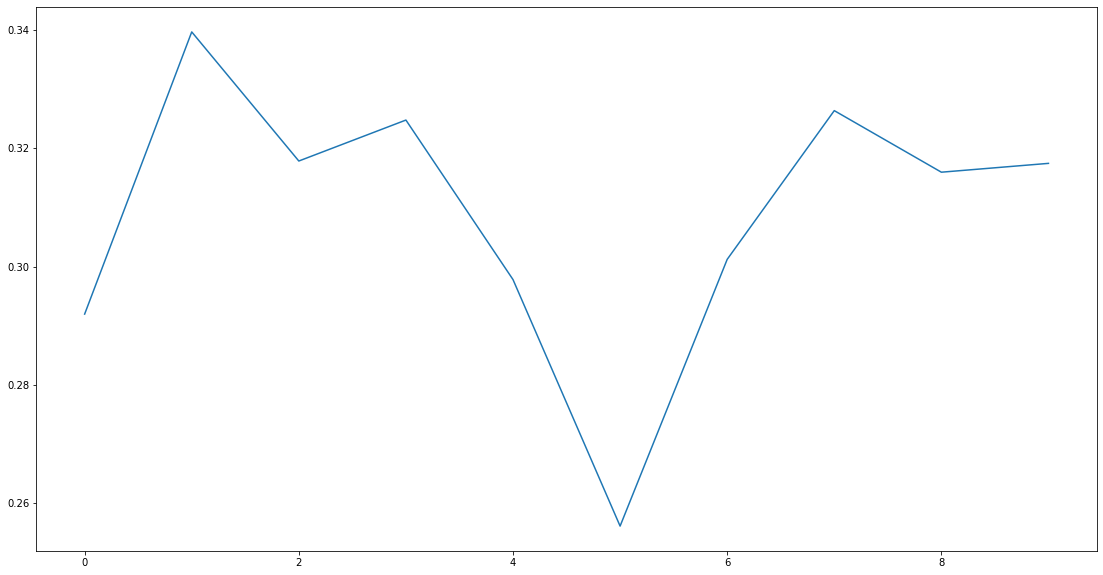

In [64]:
pd.Series(scores).plot(figsize=(19, 10));

In [65]:
scores

array([0.29195952, 0.33970363, 0.31786015, 0.324789  , 0.29779888,
       0.2560912 , 0.30121837, 0.32638481, 0.31596837, 0.31746131])

In [66]:
scores = cvScore(
    GradientBoostingClassifier(), X, y["bin"], t1=t1, scoring="f1", cv=10, pctEmbargo=0.01, sample_weight=y["w"]
)

In [67]:
np.mean(scores)

0.3073377751969616

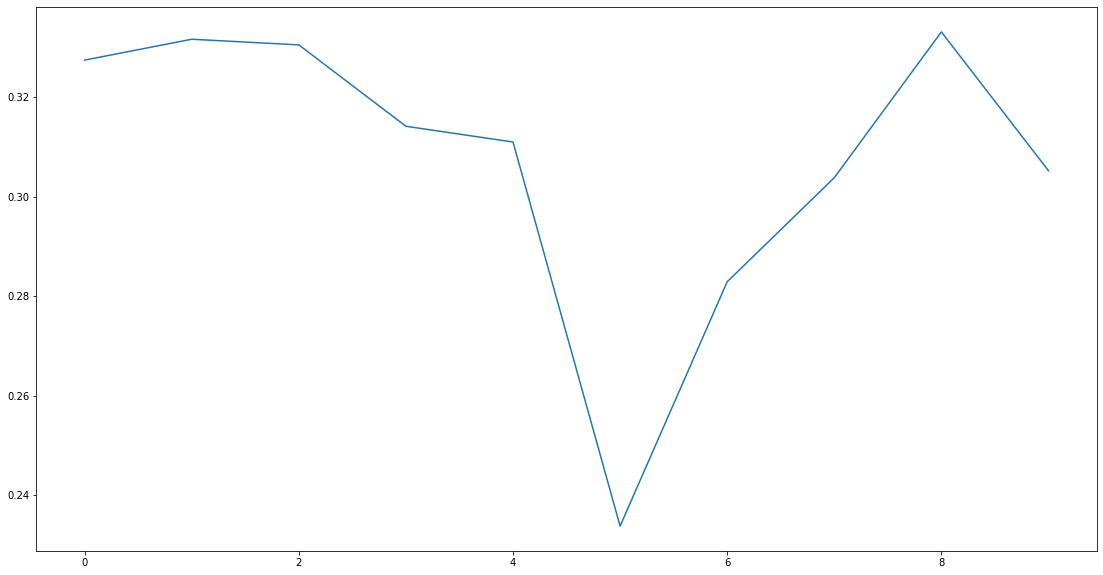

In [68]:
pd.Series(scores).plot(figsize=(19, 10));

In [69]:
scores

array([0.32741507, 0.33160699, 0.33047536, 0.31412691, 0.31096416,
       0.23382061, 0.28289506, 0.3037936 , 0.33307925, 0.30520073])

In [71]:
lgb = LGBMClassifier(
    bagging_fraction=0.7, bagging_freq=1, boosting_type='gbdt',
    class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
    importance_type='split', learning_rate=0.15, max_depth=-1,
    min_child_samples=56, min_child_weight=0.001, min_split_gain=0.2,
    n_estimators=200, n_jobs=-1, num_leaves=100, objective=None,
    random_state=957, reg_alpha=0.5, reg_lambda=1e-06, silent='warn',
    subsample=1.0, subsample_for_bin=200000, subsample_freq=0
)

In [72]:
scores = cvScore(
    lgb, X, y["bin"], t1=t1, scoring="f1", cv=10, pctEmbargo=0.01, sample_weight=y["w"]
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will b

In [73]:
scores

array([0.18368384, 0.16151312, 0.31040168, 0.23274918, 0.29667678,
       0.19121912, 0.27740932, 0.30692395, 0.3228466 , 0.30911552])

In [74]:
np.mean(scores)

0.2592539118389028

In [75]:
scores = cvScore(
    LGBMClassifier(), X, y["bin"], t1=t1, scoring="f1", cv=10, pctEmbargo=0.01, sample_weight=y["w"]
)

In [76]:
np.mean(scores)

0.3168504065960103